# Deploy a scikit-learn machine learning model to IBM Cloud



This notebook explains how to deploy a scikit-learn model to IBM Cloud usign the **watson-machine-learning-client** library that allows you to interact with the IBM Machine Learning service.

### Goal
Deploy a **Linear Regression** model that predicts the median house price in a given area in Boston. 

### Data
We will use the **Boston House Prices dataset** provided with scikit-learn. The data consists of the following columns
    - CRIM     per capita crime rate by town
    - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
    - INDUS    proportion of non-retail business acres per town
    - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    - NOX      nitric oxides concentration (parts per 10 million)
    - RM       average number of rooms per dwelling
    - AGE      proportion of owner-occupied units built prior to 1940
    - DIS      weighted distances to five Boston employment centres
    - RAD      index of accessibility to radial highways
    - TAX      full-value property-tax rate per $10,000.
    
    - PTRATIO  pupil-teacher ratio by town
    - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    - LSTAT    % lower status of the population
    - MEDV     Median value of owner-occupied homes in $1000's
    
Our goal is to predict `MEDV` assuming we have the other features/inputs available.

### Steps
1. Load the data from `scikit-learn`.
2. Explore the data / or use Data Refinery
3. Prepare data for training the model and testing the model.
4. Train the model.
5. Store the model on IBM Cloud.
6. Deploy the model on IBM Cloud.
7. Use the model deployed on IBM Cloud.



## Pre-requisites
1. Create a Machine Learning service instance (use the free plan)
https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/wml-setup.html
2. This notebook needs 
- Python 3.5
- scikit-learn 0.19.1
- watson-machine-learning-client

In [82]:
!pip install watson-machine-learning-client --upgrade
# if this is already installed, you will see a whole bunch of `Requirement already up-to-date`

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (1.0.365)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client) (2.18.4)
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client) (1.22)
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client) (4.19.5)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client) (0.21.0)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client) (2019.3.9)
Requirement not upgraded as not directly

## 1. Load the data

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

boston = load_boston()

What does the data look like ?

In [86]:
print(type(boston))
?sklearn.utils.Bunch

<class 'sklearn.utils.Bunch'>


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import warnings

In [9]:
boston = load_boston()

In [13]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='<U7')

In [22]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [23]:
# Create linear regression
regr = LinearRegression()

# Fit the linear regression
model = regr.fit(X, y)

In [24]:
model.intercept_

36.491103280363404

In [25]:
model.coef_

array([ -1.07170557e-01,   4.63952195e-02,   2.08602395e-02,
         2.68856140e+00,  -1.77957587e+01,   3.80475246e+00,
         7.51061703e-04,  -1.47575880e+00,   3.05655038e-01,
        -1.23293463e-02,  -9.53463555e-01,   9.39251272e-03,
        -5.25466633e-01])

In [ ]:
model.score()

In [26]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_766af76eecc9482cbcc075e78ca52e01 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='_b1GKarSIQRPP5CjKKlQN_vEpbLQLetnZYreF8Kbd20n',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_766af76eecc9482cbcc075e78ca52e01.get_object(Bucket='upkardemo-donotdelete-pr-lry9t1fo7eibh7',Key='boston_house_prices.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


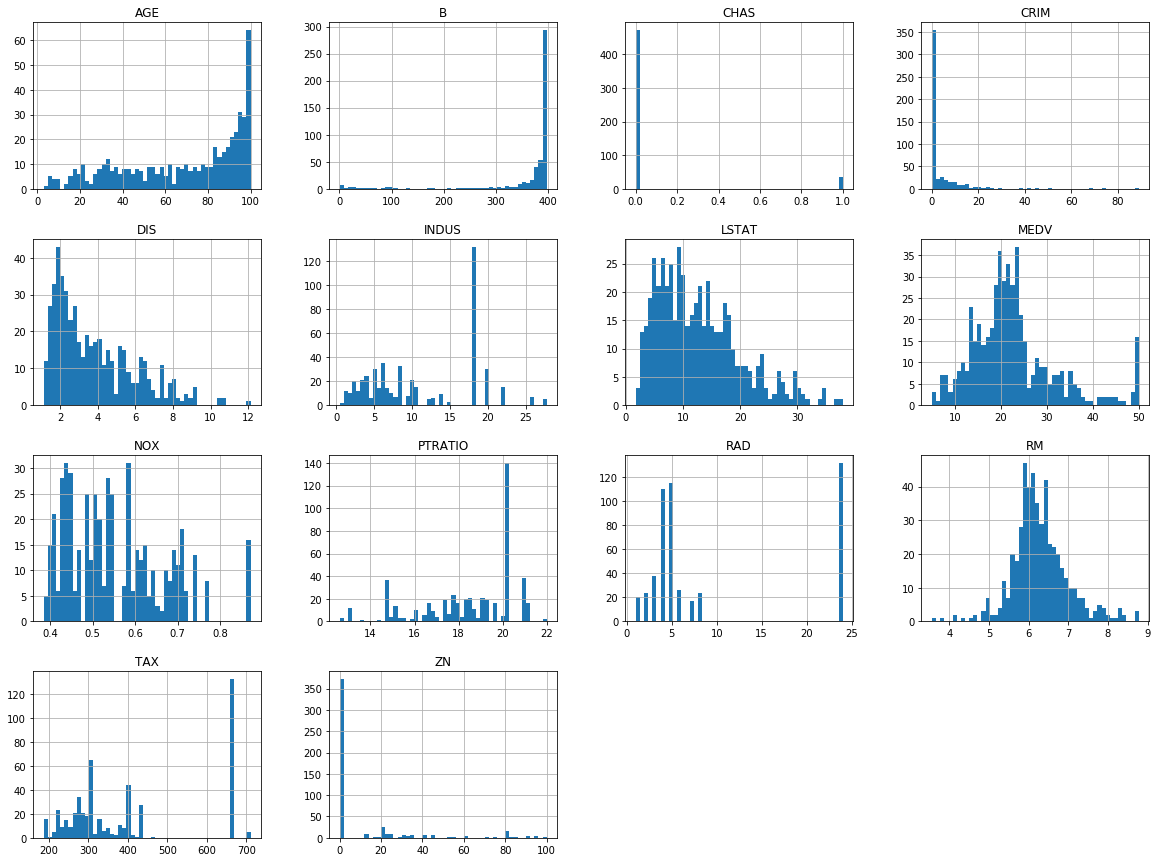

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
df_data_1.hist(bins=50, figsize=(20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb17651940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fbb173592e8>]], dtype=object)

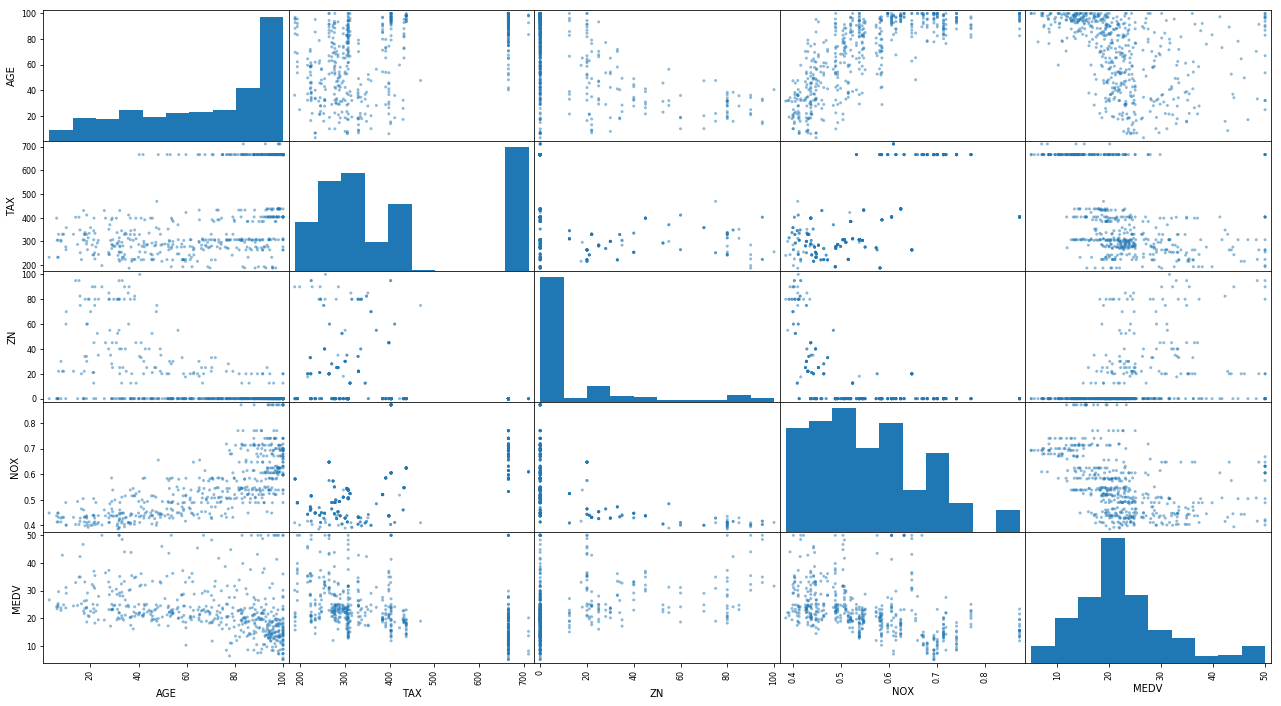

In [35]:
from pandas.plotting import scatter_matrix

attributes = ["AGE", "TAX", "ZN",
              "NOX", "MEDV"]
scatter_matrix(df_data_1[attributes], figsize=(22, 12))

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)

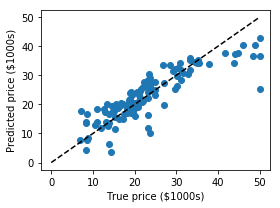

In [38]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
expected = y_test

plt.figure(figsize=(4, 3))
plt.scatter(expected, predicted)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)')
plt.tight_layout()

In [39]:
import numpy as np
print("RMS: %r " % np.sqrt(np.mean((predicted - expected) ** 2)))

plt.show()

RMS: 4.8780225836770974 


In [40]:
clf.coef_

array([ -9.95273946e-02,   4.97853297e-02,   5.63927024e-03,
         3.13458856e+00,  -1.67407915e+01,   3.40150914e+00,
         9.02437016e-03,  -1.38147797e+00,   3.30210374e-01,
        -1.29723188e-02,  -9.56873756e-01,   1.01028725e-02,
        -5.55123819e-01])

In [41]:
model.intercept_

36.491103280363404

In [43]:
# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(expected, predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(expected, predicted))

Coefficients: 
 [ -9.95273946e-02   4.97853297e-02   5.63927024e-03   3.13458856e+00
  -1.67407915e+01   3.40150914e+00   9.02437016e-03  -1.38147797e+00
   3.30210374e-01  -1.29723188e-02  -9.56873756e-01   1.01028725e-02
  -5.55123819e-01]
Mean squared error: 23.80
Variance score: 0.75


In [44]:
# deploy the linear regression model to IBMCloud
from watson_machine_learning_client import WatsonMachineLearningAPIClient

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
2019-05-20 20:20:20,613 - watson_machine_learning_client.wml_client_error - WARNING - Publishing model failed.
Reason: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Cache-Control': 'private, no-cache, no-store, must-revalidate', 'Server': 'nginx', 'X-Frame-Options': 'DENY', 'Pragma': 'no-cache', 'X-XSS-Protection': '1', 'X-Content-Type-Options': 'nosniff', 'Date': 'Mon, 20 May 2019 20:20:20 GMT', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'Connection': 'keep-alive', '

In [51]:
# Look up your Watson Machine Learning credentials and then paste them here
wml_credentials = {
  "apikey": "0BITPRhdtkqzOAjVnZPcGEmj1qsp_r4FLDF_BGsOeaCF",
  "iam_apikey_description": "Auto-generated for key d2d0d50a-2f97-4606-aa87-a556175ebbae",
  "iam_apikey_name": "upkar-real-time",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/5c734f61071b2b3d672d873ed99ead62::serviceid:ServiceId-ee2a7072-ab78-435c-a13f-f4d8af3768af",
  "instance_id": "50a98345-a085-487a-b5aa-1ce0aa7a90b5",
  "password": "f5e08ab8-8d29-4be0-874b-1f461a1105e9",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "d2d0d50a-2f97-4606-aa87-a556175ebbae"
}

# Instantiate WatsonMachineLearningAPIClient
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient( wml_credentials )


In [52]:
import json

instance_details = client.service_instance.get_details()
instance_details

{'entity': {'account': {'id': '5c734f61071b2b3d672d873ed99ead62',
   'name': "UPKAR LIDDER's Account",
   'type': 'TRIAL'},
  'deployments': {'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/50a98345-a085-487a-b5aa-1ce0aa7a90b5/deployments'},
  'organization_guid': 'N/A',
  'owner': {'beta_user': True,
   'country_code': 'CAN',
   'email': 'ulidder@us.ibm.com',
   'ibm_id': '270006CE7D',
   'user_id': '70d40a83-c2ff-48d9-96e0-08ef38a2b243'},
  'plan': 'lite',
  'plan_id': '3f6acf43-ede8-413a-ac69-f8af3bb0cbfe',
  'published_models': {'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/50a98345-a085-487a-b5aa-1ce0aa7a90b5/published_models'},
  'region': 'us-south',
  'source': 'Bluemix',
  'space_guid': 'N/A',
  'status': 'Active',
  'tags': None,
  'usage': {'capacity_units': {'current': 137060, 'limit': 180000000},
   'computation_time': {'current': 0, 'limit': 180000},
   'deployment_count': {'current': 1, 'limit': 5},
   'expiration_date': '2019-06-01T00:00:00.000Z'

In [53]:
published_model = client.repository.store_model(model=model, meta_props={'name':'boston-1'}, \
                                                training_data=X_train, training_target=y_train)

In [54]:
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

print(json.dumps(model_details, indent=2))

{
  "metadata": {
    "modified_at": "2019-05-20T20:22:02.280Z",
    "guid": "82e33b8d-6cd7-47ab-ab80-8d0067634888",
    "created_at": "2019-05-20T20:22:02.204Z",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/50a98345-a085-487a-b5aa-1ce0aa7a90b5/published_models/82e33b8d-6cd7-47ab-ab80-8d0067634888"
  },
  "entity": {
    "model_type": "scikit-learn-0.19",
    "input_data_schema": {
      "features": {
        "type": "ndarray",
        "fields": [
          {
            "type": "float",
            "name": "f0"
          },
          {
            "type": "float",
            "name": "f1"
          },
          {
            "type": "float",
            "name": "f2"
          },
          {
            "type": "float",
            "name": "f3"
          },
          {
            "type": "float",
            "name": "f4"
          },
          {
            "type": "float",
            "name": "f5"
          },
          {
            "type": "float",
            "na

In [67]:
models_details = client.repository.list_models()

------------------------------------  --------------  ------------------------  -----------------
GUID                                  NAME            CREATED                   FRAMEWORK
82e33b8d-6cd7-47ab-ab80-8d0067634888  boston-1        2019-05-20T20:22:02.204Z  scikit-learn-0.19
ed9e26e6-7ade-45c5-a6f2-65688d583011  upkar-wildfire  2019-05-17T00:09:46.083Z  wml-1.2
------------------------------------  --------------  ------------------------  -----------------


In [56]:
loaded_model = client.repository.load(published_model_uid)

In [59]:
test_predictions = loaded_model.predict(X_test[:10])
test_predictions

array([ 19.5347558 ,  25.27336772,  20.09520596,  33.18492755,
         8.78366731,   8.22260592,  13.76275951,  27.21674397,
        27.62934247,  19.20387482])

In [61]:
type(loaded_model)

sklearn.linear_model.base.LinearRegression

In [60]:
created_deployment = client.deployments.create(published_model_uid, "Deployment of scikit model")



#######################################################################################

Synchronous deployment creation for uid: '82e33b8d-6cd7-47ab-ab80-8d0067634888' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ab3314fb-d3de-47bd-9190-6326119d0957'
------------------------------------------------------------------------------------------------




In [63]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/50a98345-a085-487a-b5aa-1ce0aa7a90b5/deployments/ab3314fb-d3de-47bd-9190-6326119d0957/online


In [64]:
deployments = client.deployments.get_details()


In [66]:
deployment_url = client.deployments.get_url(created_deployment)
print(deployment_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/50a98345-a085-487a-b5aa-1ce0aa7a90b5/deployments/ab3314fb-d3de-47bd-9190-6326119d0957


In [76]:
list(X_test[0])

[0.14455000000000001,
 12.5,
 7.8700000000000001,
 0.0,
 0.52400000000000002,
 6.1719999999999997,
 96.099999999999994,
 5.9504999999999999,
 5.0,
 311.0,
 15.199999999999999,
 396.89999999999998,
 19.149999999999999]

In [77]:
scoring_payload = {"values": [list(X_test[0]), list(X_test[1])]}
predictions = client.deployments.score(scoring_endpoint, scoring_payload)

In [78]:
print(json.dumps(predictions, indent=2))

{
  "values": [
    [
      19.534755802207023
    ],
    [
      25.273367717625323
    ]
  ],
  "fields": [
    "prediction"
  ]
}


Automatically created module for IPython interactive environment
Coefficients: 
 [ 938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


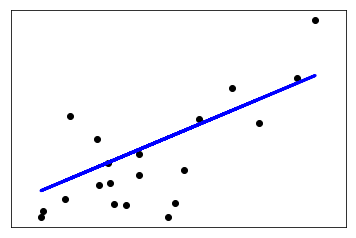

In [42]:
print(__doc__)


# Code source: Jaques Grobler
# License: BSD 3 clause


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()
